In [7]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import sounddevice as sd
%matplotlib inline

In [324]:
fs = 44100

nperseg=4096
noverlap=int(3/4 * nperseg)
#fs = 10e3
N = 3*fs

myrec = sd.rec(int(N), samplerate=fs, channels=1)

(0, 5000)

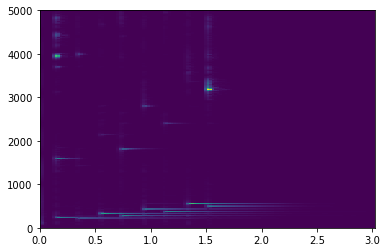

In [325]:
f, t, s_stft = sig.stft(myrec[:, 0], fs=fs, nperseg=nperseg, noverlap=noverlap)
plt.pcolormesh(t, f, np.abs(s_stft))
plt.ylim([0, 5000])

In [326]:
s_mag = np.abs(s_stft)[1:]
s_mag_pad = np.vstack([np.zeros((2, s_mag.shape[1])), s_mag])
s_mag_pad = np.vstack([s_mag_pad, np.zeros((2, s_mag.shape[1]))])
s_mag_l = s_mag_pad[1:-3]
s_mag_r = s_mag_pad[3:-1]
s_mag_l2 = s_mag_pad[0:-4]
s_mag_r2 = s_mag_pad[4:]         
peaks = np.logical_and(np.greater(s_mag, s_mag_l), np.greater(s_mag, s_mag_r))
peaks2 = np.logical_and(np.greater(s_mag, s_mag_l2), np.greater(s_mag, s_mag_r2))
peaks = np.logical_and(peaks, peaks2)

(0, 5000)

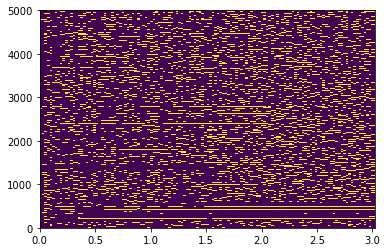

In [327]:
plt.pcolormesh(t, f, peaks)
plt.ylim([0, 5000])

In [328]:
df = (nperseg/fs)
t_hop = fs*noverlap
def transform_freq(beta, s, peaks, freqs):
    
    N, l = np.shape(s)
    s_new = np.zeros(s.shape).astype(type(s[1,1]))
    cum_phase = np.ones(N).astype('complex128')
    for b in range(l):
        vec = s[:, b]
        peak_inds = np.nonzero(peaks[:, b])[0]
        peak_freqs = freqs[peak_inds]
        Rbdys = np.zeros(len(peak_inds)+1)
        Rbdys[-1] = int(N)
        Rbdys[1:-1] = np.round((peak_inds[1:] + peak_inds[0:-1])/2).astype(int)
        for ind, p in enumerate(peak_inds):
            
            omega = freqs[p]
            domega = omega*(beta-1)
            onew = beta*omega
            phase_factor = np.exp(1j * domega*t_hop)
            ind_new = np.round(df*onew)
            i_p = int(ind_new + (Rbdys[ind+1]-p))
            i_l = int(ind_new + (Rbdys[ind]-p))
            #print(p, i_p, i_l, ind_new, omega, onew)
            if(i_l < N and i_p < N):
                cum_phase[i_l:i_p] *= phase_factor
                s_new[i_l:i_p, b] += np.multiply(s[int(Rbdys[ind]):int(Rbdys[ind+1]), b], cum_phase[i_l:i_p])
    return s_new

In [329]:
s_new = transform_freq(1.15, s_stft, peaks, f)

(0, 7000)

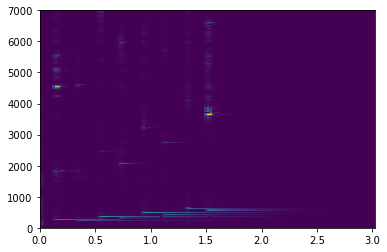

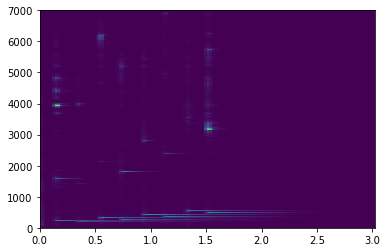

In [330]:
plt.pcolormesh(t, f, np.abs(s_new))
plt.ylim([0, 7000])
plt.figure()
plt.pcolormesh(t, f, np.abs(s_stft))
plt.ylim([0, 7000])

In [332]:
t2, z = sig.istft(s_new, fs=fs, noverlap=noverlap)
sd.play(z, samplerate=fs)

In [333]:
sd.play(myrec, samplerate=fs)